In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import ParameterGrid
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])

# Load the MNIST dataset
mnist_data = datasets.MNIST(root="../../data", train=True, download=True, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_data, val_data = random_split(mnist_data, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.91MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 163kB/s]
100%|██████████| 1.65M/1.65M [00:02<00:00, 766kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.52MB/s]


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Placeholder for the flattened size
        self.flattened_size = None
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # This will be updated dynamically
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        
        # Dynamically calculate the flattened size
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).size(1)
            self.fc1 = nn.Linear(self.flattened_size, 128).to(x.device)
        
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

In [13]:
# Define hyperparameter grid
param_grid = {
    "lr": [0.001, 0.01],
    "batch_size": [32, 64],
    "epochs": [5, 10]
}
grid = list(ParameterGrid(param_grid))

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = []

for params in grid:
    print(f"Training with params: {params}")
    
    # Update DataLoader with new batch size
    train_loader = DataLoader(train_data, batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=params["batch_size"], shuffle=False)
    
    # Initialize model, criterion, and optimizer
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params["lr"])
    
    # Train and evaluate the model
    for epoch in range(params["epochs"]):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        print(f"Epoch {epoch+1}/{params['epochs']}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    
    # Store results
    results.append({
        "params": params,
        "val_accuracy": val_accuracy
    })

Training with params: {'batch_size': 32, 'epochs': 5, 'lr': 0.001}
Epoch 1/5, Train Loss: 0.4014, Val Loss: 0.1623, Val Accuracy: 0.9501
Epoch 2/5, Train Loss: 0.1408, Val Loss: 0.1242, Val Accuracy: 0.9633
Epoch 3/5, Train Loss: 0.1056, Val Loss: 0.0928, Val Accuracy: 0.9707
Epoch 4/5, Train Loss: 0.0891, Val Loss: 0.1005, Val Accuracy: 0.9680
Epoch 5/5, Train Loss: 0.0788, Val Loss: 0.0793, Val Accuracy: 0.9730
Training with params: {'batch_size': 32, 'epochs': 5, 'lr': 0.01}
Epoch 1/5, Train Loss: 0.2287, Val Loss: 0.1325, Val Accuracy: 0.9557
Epoch 2/5, Train Loss: 0.1182, Val Loss: 0.1125, Val Accuracy: 0.9647
Epoch 3/5, Train Loss: 0.0989, Val Loss: 0.1069, Val Accuracy: 0.9672
Epoch 4/5, Train Loss: 0.0853, Val Loss: 0.0870, Val Accuracy: 0.9737
Epoch 5/5, Train Loss: 0.0791, Val Loss: 0.0883, Val Accuracy: 0.9755
Training with params: {'batch_size': 32, 'epochs': 10, 'lr': 0.001}
Epoch 1/10, Train Loss: 0.3921, Val Loss: 0.1825, Val Accuracy: 0.9464
Epoch 2/10, Train Loss: 0.15

Best Hyperparameters: {'batch_size': 32, 'epochs': 5, 'lr': 0.01}
Best Validation Accuracy: 0.9755


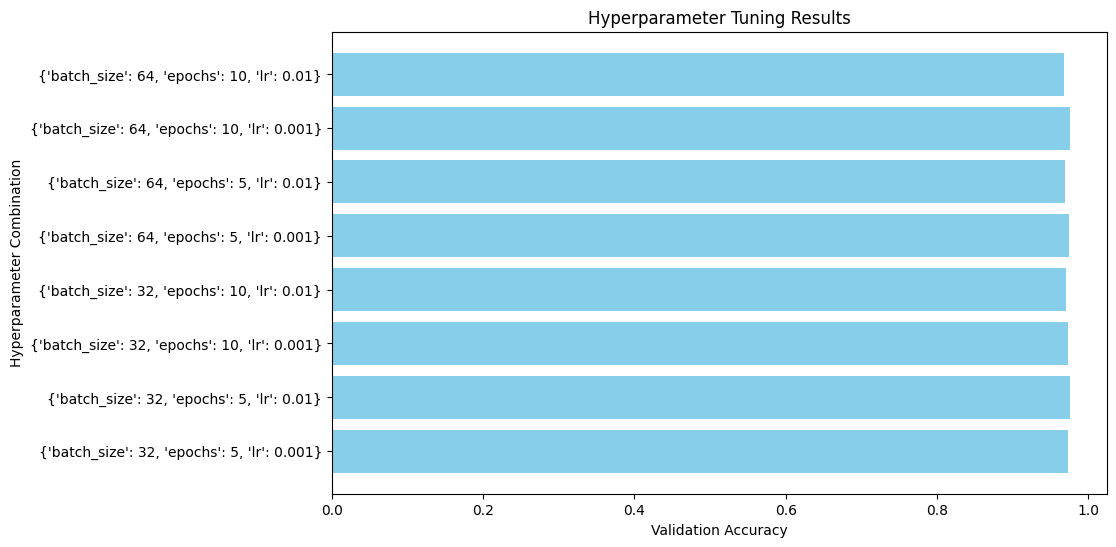

In [17]:
# Find the best hyperparameters
best_result = max(results, key=lambda x: x["val_accuracy"])
print("Best Hyperparameters:", best_result["params"])
print("Best Validation Accuracy:", best_result["val_accuracy"])

# Visualize results
param_combinations = [str(r["params"]) for r in results]
accuracies = [r["val_accuracy"] for r in results]

plt.figure(figsize=(10, 6))
plt.barh(param_combinations, accuracies, color="skyblue")
plt.xlabel("Validation Accuracy")
plt.ylabel("Hyperparameter Combination")
plt.title("Hyperparameter Tuning Results")
plt.show()